In [598]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow
import gpflux
import sklearn
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm

In [599]:
import random
import warnings
warnings.filterwarnings('ignore')

In [600]:
random.seed(7)
df = pd.read_csv("Real estate.csv")
tf.keras.backend.set_floatx("float64")

In [601]:
X = np.array(df.drop(['No','Y house price of unit area'], axis=1))
Y = np.array(df['Y house price of unit area'])

In [602]:
X = np.reshape(X,(-1,6))
Y = np.reshape(Y, (-1,1))

In [603]:
indexes = np.arange(len(Y))
np.random.shuffle(indexes)
X = X[indexes]
Y = Y[indexes]

In [604]:
X_train = X[0:290]
X_val = X[290:352]
X_test = X[352:414]

In [605]:
Y_train = Y[0:290]
Y_val = Y[290:352]
Y_test = Y[352:414]

In [606]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [607]:
n = len(Y_train)

In [608]:
kernels = [gpflow.kernels.Matern12(), gpflow.kernels.Matern32(), gpflow.kernels.Matern52(), gpflow.kernels.RBF(),
           gpflow.kernels.RationalQuadratic(), gpflow.kernels.Cosine(), 
           gpflow.kernels.Periodic(base_kernel=gpflow.kernels.RBF())]

In [609]:
mse_val = np.empty(15, dtype=float)
mae_val = np.empty(15, dtype=float)
i=0

In [610]:
for k in kernels:
    kernel1 = k
    inducing_points1 = gpflow.inducing_variables.InducingPoints(np.random.random((32, 6)))
    layer1 = gpflux.layers.GPLayer(kernel1,inducing_points1,num_data=n,num_latent_gps=1,
                                  mean_function=gpflow.mean_functions.Zero())
    likelihood = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian())
    gp = gpflux.models.DeepGP([layer1],likelihood)
    model = gp.as_training_model()
    model.compile(tf.optimizers.Adam(0.01))
    model.fit({"inputs":X_train,"targets":Y_train},epochs=150,verbose=0)
    model = gp.as_prediction_model()
    out_val = model(X_val)
    pred_val = out_val.f_mean.numpy().squeeze()
    mse_val[i] = metrics.mean_squared_error(Y_val,pred_val)
    mae_val[i] = metrics.mean_absolute_error(Y_val,pred_val)
    i = i+1

In [611]:
mse_val

array([3.03615103e+001, 3.07115952e+001, 3.46917575e+001, 3.51937674e+001,
       2.96066082e+001, 1.52192711e+003, 7.71077660e+001, 3.18299369e-313,
       3.60739285e-313, 4.03179200e-313, 4.45619116e-313, 4.88059032e-313,
       5.30498948e-313, 5.72938864e-313, 6.15378780e-313])

In [612]:
mae_val

array([3.87578055e+000, 3.95150365e+000, 4.20041356e+000, 4.27201536e+000,
       3.79169829e+000, 3.66967433e+001, 6.62920635e+000, 3.18299369e-313,
       3.60739285e-313, 4.03179200e-313, 4.45619116e-313, 4.88059032e-313,
       5.30498948e-313, 5.72938864e-313, 6.15378780e-313])

In [613]:
kernel1 = gpflow.kernels.Matern12() + gpflow.kernels.Matern32() + gpflow.kernels.Matern52()+ gpflow.kernels.RBF()+gpflow.kernels.RationalQuadratic()+ gpflow.kernels.Cosine()+ gpflow.kernels.Periodic(base_kernel=gpflow.kernels.RBF())
inducing_points1 = gpflow.inducing_variables.InducingPoints(np.random.random((32, 6)))
layer1 = gpflux.layers.GPLayer(kernel1,inducing_points1,num_data=n,num_latent_gps=6)
kernel2 = gpflow.kernels.Matern12() + gpflow.kernels.Matern32() + gpflow.kernels.Matern52()+ gpflow.kernels.RBF()+gpflow.kernels.RationalQuadratic()+ gpflow.kernels.Cosine()+ gpflow.kernels.Periodic(base_kernel=gpflow.kernels.RBF())
inducing_points2 = gpflow.inducing_variables.InducingPoints(np.random.random((16, 6)))
layer2 = gpflux.layers.GPLayer(kernel2,inducing_points2,num_data =n,num_latent_gps=1,mean_function=gpflow.mean_functions.Zero())

In [614]:
likelihood = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian())
deep_gp = gpflux.models.DeepGP([layer1, layer2],likelihood)
model = deep_gp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))
model.fit({"inputs":X_train,"targets":Y_train},epochs=150,verbose=0);

In [615]:
model1 = deep_gp.as_prediction_model()
out_train = model1(X_train)
out_val = model1(X_val)
pred_train = out_train.f_mean.numpy().squeeze()
pred_val = out_val.f_mean.numpy().squeeze()

In [616]:
metrics.mean_squared_error(Y_train,pred_train)

194.61778711650732

In [617]:
metrics.mean_absolute_error(Y_train,pred_train)

10.768622387708946

In [618]:
metrics.mean_squared_error(Y_val,pred_val)

160.3917648413938

In [619]:
metrics.mean_absolute_error(Y_val,pred_val)

10.660927448930009

In [620]:
mse_val[7] = metrics.mean_squared_error(Y_val,pred_val)
mae_val[7] = metrics.mean_absolute_error(Y_val,pred_val)

In [621]:
kernel1 = gpflow.kernels.RBF()
inducing_points1 = gpflow.inducing_variables.InducingPoints(np.random.random((32, 6)))
layer1 = gpflux.layers.GPLayer(kernel1,inducing_points1,num_data=n,num_latent_gps=6)
kernel2 = gpflow.kernels.Matern12()
inducing_points2 = gpflow.inducing_variables.InducingPoints(np.random.random((16, 6)))
layer2 = gpflux.layers.GPLayer(kernel2,inducing_points2,num_data =n,num_latent_gps=1,mean_function=gpflow.mean_functions.Zero())

In [622]:
likelihood = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian())
deep_gp = gpflux.models.DeepGP([layer1, layer2],likelihood)
model = deep_gp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))
model.fit({"inputs":X_train,"targets":Y_train},epochs=150,verbose=0);

In [623]:
model2 = deep_gp.as_prediction_model()
out_train = model2(X_train)
out_val = model2(X_val)
pred_train = out_train.f_mean.numpy().squeeze()
pred_val = out_val.f_mean.numpy().squeeze()

In [624]:
metrics.mean_squared_error(Y_train,pred_train)

55.51770268324888

In [625]:
metrics.mean_absolute_error(Y_train,pred_train)

4.9976349086574325

In [626]:
metrics.mean_squared_error(Y_val,pred_val)

34.84816281556302

In [627]:
metrics.mean_absolute_error(Y_val,pred_val)

4.290339731550978

In [628]:
mse_val[8] = metrics.mean_squared_error(Y_val,pred_val)
mae_val[8] = metrics.mean_absolute_error(Y_val,pred_val)

In [629]:
kernel1 = gpflow.kernels.RBF()*gpflow.kernels.Linear()
inducing_points1 = gpflow.inducing_variables.InducingPoints(np.random.random((32, 6)))
layer1 = gpflux.layers.GPLayer(kernel1,inducing_points1,num_data=n,num_latent_gps=6)
kernel2 = gpflow.kernels.Matern12()*gpflow.kernels.Linear()
inducing_points2 = gpflow.inducing_variables.InducingPoints(np.random.random((16, 6)))
layer2 = gpflux.layers.GPLayer(kernel2,inducing_points2,num_data =n,num_latent_gps=1,mean_function=gpflow.mean_functions.Zero())

In [630]:
likelihood = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian())
deep_gp = gpflux.models.DeepGP([layer1, layer2],likelihood)
model = deep_gp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))
model.fit({"inputs":X_train,"targets":Y_train},epochs=150,verbose=0);

In [631]:
model3 = deep_gp.as_prediction_model()
out_train = model3(X_train)
out_val = model3(X_val)
pred_train = out_train.f_mean.numpy().squeeze()
pred_val = out_val.f_mean.numpy().squeeze()

In [632]:
metrics.mean_squared_error(Y_train,pred_train)

70.45169738151651

In [633]:
metrics.mean_absolute_error(Y_train,pred_train)

6.023298540783055

In [634]:
metrics.mean_squared_error(Y_val,pred_val)

55.76627724985637

In [635]:
metrics.mean_absolute_error(Y_val,pred_val)

5.880273651640128

In [636]:
mse_val[9] = metrics.mean_squared_error(Y_val,pred_val)
mae_val[9] = metrics.mean_absolute_error(Y_val,pred_val)

In [637]:
kernel1 = gpflow.kernels.RBF()*gpflow.kernels.Linear()*gpflow.kernels.Periodic(base_kernel=gpflow.kernels.RBF())
inducing_points1 = gpflow.inducing_variables.InducingPoints(np.random.random((32, 6)))
layer1 = gpflux.layers.GPLayer(kernel1,inducing_points1,num_data=n,num_latent_gps=6)
kernel2 = gpflow.kernels.RationalQuadratic()
inducing_points2 = gpflow.inducing_variables.InducingPoints(np.random.random((16, 6)))
layer2 = gpflux.layers.GPLayer(kernel2,inducing_points2,num_data =n,num_latent_gps=1,mean_function=gpflow.mean_functions.Zero())

In [638]:
likelihood = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian())
deep_gp = gpflux.models.DeepGP([layer1, layer2],likelihood)
model = deep_gp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))
model.fit({"inputs":X_train,"targets":Y_train},epochs=150,verbose=0);

In [639]:
model4 = deep_gp.as_prediction_model()
out_train = model4(X_train)
out_val = model4(X_val)
pred_train = out_train.f_mean.numpy().squeeze()
pred_val = out_val.f_mean.numpy().squeeze()

In [640]:
metrics.mean_squared_error(Y_train,pred_train)

64.33911047449084

In [641]:
metrics.mean_absolute_error(Y_train,pred_train)

5.327363825415763

In [642]:
metrics.mean_squared_error(Y_val,pred_val)

28.385104634265385

In [643]:
metrics.mean_absolute_error(Y_val,pred_val)

3.6208430868226507

In [644]:
mse_val[10] = metrics.mean_squared_error(Y_val,pred_val)
mae_val[10] = metrics.mean_absolute_error(Y_val,pred_val)

In [645]:
kernel1 = gpflow.kernels.RBF()
inducing_points1 = gpflow.inducing_variables.InducingPoints(np.random.random((32, 6)))
layer1 = gpflux.layers.GPLayer(kernel1,inducing_points1,num_data=n,num_latent_gps=6)
kernel2 = gpflow.kernels.RBF()
inducing_points2 = gpflow.inducing_variables.InducingPoints(np.random.random((16, 6)))
layer2 = gpflux.layers.GPLayer(kernel2,inducing_points2,num_data=n,num_latent_gps=6)
kernel3 = gpflow.kernels.RBF()
inducing_points3 = gpflow.inducing_variables.InducingPoints(np.random.random((16, 6)))
layer3 = gpflux.layers.GPLayer(kernel3,inducing_points3,num_data =n,num_latent_gps=1,mean_function=gpflow.mean_functions.Zero())

In [646]:
likelihood = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian())
deep_gp = gpflux.models.DeepGP([layer1, layer2, layer3],likelihood)
model = deep_gp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))
model.fit({"inputs":X_train,"targets":Y_train},epochs=150,verbose=0);

In [647]:
model5 = deep_gp.as_prediction_model()
out_train = model5(X_train)
out_val = model5(X_val)
pred_train = out_train.f_mean.numpy().squeeze()
pred_val = out_val.f_mean.numpy().squeeze()

In [648]:
metrics.mean_squared_error(Y_train,pred_train)

61.08790266137472

In [649]:
metrics.mean_absolute_error(Y_train,pred_train)

5.2969138585705355

In [650]:
metrics.mean_squared_error(Y_val,pred_val)

35.62475537805778

In [651]:
metrics.mean_absolute_error(Y_val,pred_val)

4.127348365715865

In [652]:
mse_val[11] = metrics.mean_squared_error(Y_val,pred_val)
mae_val[11] = metrics.mean_absolute_error(Y_val,pred_val)

In [653]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [654]:
model6 = Sequential([InputLayer(6,),Dense(32, activation='relu'), Dense(1)])
model6.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(),
              metrics = [MeanAbsoluteError()])

In [655]:
history = model6.fit(X_train,Y_train,epochs=150, batch_size=16, validation_data=(X_val,Y_val), verbose=0)

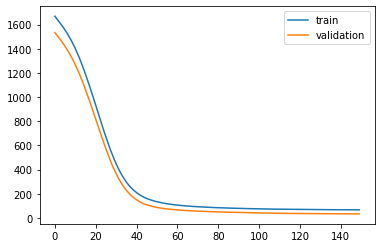

2/2 [==============================] - 0s 31ms/step - loss: 33.1471 - mean_absolute_error: 4.1363


In [656]:
plt.plot(history.epoch,history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()
train_mse6, train_mae6 = model6.evaluate(X_train,Y_train)
val_mse6, val_mae6 = model6.evaluate(X_val,Y_val)

In [657]:
mse_val[12] = val_mse6
mae_val[12] = val_mae6

In [658]:
model7 = sklearn.linear_model.LinearRegression()

In [659]:
model7.fit(X_train, Y_train)

LinearRegression()

In [660]:
pred_train = model7.predict(X_train)
pred_val = model7.predict(X_val)

In [661]:
metrics.mean_squared_error(Y_train,pred_train)

86.87071891587512

In [662]:
metrics.mean_absolute_error(Y_train,pred_train)

6.387180359412174

In [663]:
metrics.mean_squared_error(Y_val,pred_val)

33.27960114935964

In [664]:
metrics.mean_absolute_error(Y_val,pred_val)

4.413194169177652

In [665]:
mse_val[13] = metrics.mean_squared_error(Y_val,pred_val)
mae_val[13] = metrics.mean_absolute_error(Y_val,pred_val)

In [666]:
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [667]:
best_mse = 100000
best_C = None
best_gamma = None
model8 = None

In [668]:
for C in Cs:
    for gamma in gammas:
        model = svm.SVR(kernel='rbf', gamma=gamma, C = C)
        model.fit(X_train, Y_train)
        mse = metrics.mean_squared_error(Y_val, model.predict(X_val))
        if mse < best_mse:
            best_mse = mse
            best_C = C
            best_gamma = gamma
            model8 = model

In [669]:
best_C

1000

In [670]:
best_gamma

0.01

In [671]:
pred_train = model8.predict(X_train)
pred_val = model8.predict(X_val)

In [672]:
metrics.mean_squared_error(Y_train,pred_train)

63.72561582806899

In [673]:
metrics.mean_absolute_error(Y_train,pred_train)

4.758119377267771

In [674]:
metrics.mean_squared_error(Y_val,pred_val)

25.13096969656022

In [675]:
metrics.mean_absolute_error(Y_val,pred_val)

3.7291020909660824

In [676]:
mse_val[14] = metrics.mean_squared_error(Y_val,pred_val)
mae_val[14] = metrics.mean_absolute_error(Y_val,pred_val)

In [677]:
mse_val

array([  30.36151035,   30.71159519,   34.69175748,   35.19376741,
         29.60660821, 1521.92711192,   77.10776601,  160.39176484,
         34.84816282,   55.76627725,   28.38510463,   35.62475538,
         33.14712662,   33.27960115,   25.1309697 ])

In [678]:
mae_val

array([ 3.87578055,  3.95150365,  4.20041356,  4.27201536,  3.79169829,
       36.69674334,  6.62920635, 10.66092745,  4.29033973,  5.88027365,
        3.62084309,  4.12734837,  4.13630178,  4.41319417,  3.72910209])